<a href="https://colab.research.google.com/github/vishalrk1/Fake-News-Detection/blob/main/Fake_News_detction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam, SGD

In [5]:
train_df = pd.read_csv('/content/drive/MyDrive/Datasets/news.csv')

In [6]:
train_df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


#EDA

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6335 entries, 0 to 6334
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6335 non-null   int64 
 1   title       6335 non-null   object
 2   text        6335 non-null   object
 3   label       6335 non-null   object
dtypes: int64(1), object(3)
memory usage: 198.1+ KB


In [8]:
train_df['label'].value_counts()

REAL    3171
FAKE    3164
Name: label, dtype: int64

In [9]:
train_df['label'] = train_df['label'].map({'FAKE':0, 'REAL':1})
train_df.head()

,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


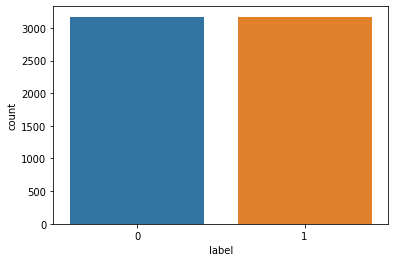

In [10]:
sns.countplot(x="label", data=train_df)

In [11]:
train_df = train_df.drop('Unnamed: 0', axis=1)
train_df

,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1
...,...,...,...
6330,State Department says it can't find emails fro...,The State Department told the Republican Natio...,1
6331,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,0
6332,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,0
6333,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",1


**So For this project we are only using text column of given dataset***

In [12]:
# shuffeling train data
train_df_shuffled = train_df.sample(frac=1, random_state=42)

In [13]:
train_df_shuffled.head()

,title,text,label
1357,"American Dream, Revisited",Will Trump pull a Brexit times ten? What would...,0
2080,Clintons Are Under Multiple FBI Investigations...,Clintons Are Under Multiple FBI Investigations...,0
2718,The FBI Can’t Actually Investigate a Candidate...,Dispatches from Eric Zuesse This piece is cros...,0
812,Confirmed: Public overwhelmingly (10-to-1) say...,Print \n[Ed. – Every now and then the facade c...,0
4886,Nanny In Jail After Force Feeding Baby To Death,Nanny In Jail After Force Feeding Baby To Deat...,0


In [14]:
train_df_shuffled.isnull().sum()

title    0
text     0
label    0
dtype: int64

##Printing Some ranf=dom news samples

In [15]:
import random
random_index = random.randint(0, len(train_df)-5)

for row in train_df_shuffled[['text', 'label']][random_index:random_index+1].itertuples():
  _, text, target = row
  print(f"Target: {target}", '(Real News)' if target > 0 else '(Fake News)')
  print(f"News: {text}")
  print('---\n')

Target: 0 (Fake News)
News: 14 Shares
4 9 0 1
It's a heartwarming moment amid the carnage of the battle to liberate Mosul.
An Iraqi lieutenant -- part of the elite Golden Division special forces fighting to take back Iraq's second city from ISIS -- was stationed at a checkpoint in Bartella, about 25 kilometers to the east of the city, when he spotted some familiar faces Tuesday.
Amid a group of refugees fleeing the city's outskirts were his mother, his father, and his nephew, whom the soldier had been separated from for over two years.
The soldier gave his name as 1st. Lt. Salam to the CNN producer who captured the moment.
After embracing a group of adults, including his mother, father and brother, he picks up his young nephew and holds him, walking away from the group. He then falls to his knees and kisses him, before picking him up and carrying him away. The joy on both their faces obvious to all.
MORE... Muslim Iraqi Soldiers Erect Cross on Top of the Church in Newly Liberated Karam

# Preprocessing Data

In [16]:
# import my nlp helper script
from nlp_helper import remove_html, remove_punctuation, remove_stopwords, lowercase_text, word_lemmatizer, word_stemmer

import nltk
from nltk.tokenize import RegexpTokenizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [17]:
text_data = train_df_shuffled['text'].tolist()
text_data[0]

'Will Trump pull a Brexit times ten? What would it take, beyond WikiLeaks, to bring the Clinton (cash) machine down? Will Hillary win and then declare WWIII against her Russia/Iran/Syria “axis of evil”? Will the Middle East totally explode? Will the pivot to Asia totally implode? Will China be ruling the world by 2025?\nAmidst so many frenetic fragments of geopolitical reality precariously shored against our ruins, the temptation is irresistible to hark back to the late, great, deconstructionist master Jean Baudrillard. During the post-mod 1980s it was hip to be Baudrillardian to the core; his America, originally published in France in 1986, should still be read today as the definitive metaphysical/geological/cultural Instagram of Exceptionalistan.\nBy the late 1990s, at the end of the millennium, two years before 9/11 – that seminal “before and after” event – Baudrillard was already stressing how we live in a black market maze. Now, it’s a black market paroxysm.\nGlobal multitudes are

### Removing HTML words

In [18]:
text_data = train_df_shuffled['text'].apply(lambda x: remove_html(x))

### Removing Punctuations

In [19]:
text_data = text_data.apply(lambda x: remove_punctuation(x))
text_data[:2]

1357    Will Trump pull a Brexit times ten What would ...
2080    Clintons Are Under Multiple FBI Investigations...
Name: text, dtype: object

### Lowercasing all words

In [20]:
text_data = text_data.apply(lambda x: lowercase_text(x))
text_data[:2]

1357    [will, trump, pull, a, brexit, times, ten, wha...
2080    [clintons, are, under, multiple, fbi, investig...
Name: text, dtype: object

### Lemmanizing words

In [21]:
text_data = text_data.apply(lambda x: word_lemmatizer(x))
text_data[:2]

1357    [will, trump, pull, a, brexit, time, ten, what...
2080    [clinton, are, under, multiple, fbi, investiga...
Name: text, dtype: object

### Stemmerizing

In [22]:
text_data = text_data.apply(lambda x: word_stemmer(x))
text_data[:2]

1357    will trump pull a brexit time ten what would i...
2080    clinton are under multipl fbi investig a agent...
Name: text, dtype: object

# Train anc validation split

In [23]:
from sklearn.model_selection import train_test_split


In [24]:
len(text_data)

6335

In [25]:
train_news, val_news, train_label, val_label = train_test_split(text_data, train_df_shuffled['label'], test_size=0.2, random_state=101)

In [26]:
train_news.shape, val_news.shape

((5068,), (1267,))

**Calculating maximum length of text**

In [27]:
round(sum([len(i.split()) for i in train_news])/ len(train_news))

786

#Converting text into numbers

* Vectorization Layer
* Embedding Layer

In [28]:
from tensorflow.keras.layers import TextVectorization, Embedding

In [29]:
max_vocab_length = 10000
max_length = 790

text_vectorizer = TextVectorization(
    max_tokens=max_vocab_length,
    output_mode='int',
    output_sequence_length=max_length,
)

In [30]:
text_vectorizer.adapt(train_news)

In [31]:
embedding = Embedding(
    input_dim = max_vocab_length, 
    output_dim = 128,
    input_length = max_length,
)

#Some helpful Functions

In [32]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_result(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
  model_results = {
      'accurecy': accuracy,
      'precision': model_precision,
      'recall': model_recall,
      'f1-score': model_f1,
  }

  return model_results

In [33]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

# importing helper function
from helper_functions import create_tensorboard_callback, plot_loss_curves, pred_and_plot, unzip_data, walk_through_dir

--2021-12-19 09:59:01--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-12-19 09:59:01 (25.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



#Model Experiments

## Callbacks

In [50]:
early_stopping = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=3,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5,
        patience=2, verbose=1
    ),
]

##1. NavieBase Model

In [51]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [52]:
model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB()),
])

In [53]:
model_0.fit(train_news, train_label)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [54]:
model_0.score(val_news, val_label)

0.7734806629834254

In [55]:
model_0_perd = model_0.predict(val_news) 

model_0_result = calculate_result(val_label, model_0_perd)
model_0_result

{'accurecy': 0.7734806629834254,
 'f1-score': 0.7653864196239786,
 'precision': 0.8327285259750007,
 'recall': 0.7734806629834254}

##1. Simple Dense layer model

In [56]:
train_news_data = tf.data.Dataset.from_tensor_slices(train_news)
train_label_data = tf.data.Dataset.from_tensor_slices(train_label)

train_dataset = tf.data.Dataset.zip((train_news_data, train_label_data)).batch(32).prefetch(tf.data.AUTOTUNE)

In [57]:
val_news_data = tf.data.Dataset.from_tensor_slices(val_news)
val_label_data = tf.data.Dataset.from_tensor_slices(val_label)

val_dataset = tf.data.Dataset.zip((val_news_data, val_label_data)).batch(32).prefetch(tf.data.AUTOTUNE)

In [58]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GlobalAvgPool1D()(x)
x = layers.Dense(64, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_1 = tf.keras.Model(inputs, outputs)

In [59]:
model_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 790)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 790, 128)          1280000   
                                                                 
 global_average_pooling1d_1   (None, 128)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65  

In [60]:
model_1.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(),
    metrics = ['accuracy'],
)

history_1 = model_1.fit(
    train_dataset,
    epochs = 10,
    validation_data = val_dataset,
)

Epoch 1/10
159/159 [==============================] - 4s 18ms/step - loss: 0.3841 - accuracy: 0.9000 - val_loss: 0.2460 - val_accuracy: 0.9298
Epoch 2/10
159/159 [==============================] - 3s 16ms/step - loss: 0.1243 - accuracy: 0.9714 - val_loss: 0.2265 - val_accuracy: 0.9187
Epoch 3/10
159/159 [==============================] - 3s 16ms/step - loss: 0.0724 - accuracy: 0.9850 - val_loss: 0.2473 - val_accuracy: 0.9045
Epoch 4/10
159/159 [==============================] - 3s 16ms/step - loss: 0.0496 - accuracy: 0.9891 - val_loss: 0.2689 - val_accuracy: 0.9013
Epoch 5/10
159/159 [==============================] - 2s 16ms/step - loss: 0.0372 - accuracy: 0.9911 - val_loss: 0.2861 - val_accuracy: 0.9037
Epoch 6/10
159/159 [==============================] - 2s 16ms/step - loss: 0.0295 - accuracy: 0.9925 - val_loss: 0.3015 - val_accuracy: 0.9069
Epoch 7/10
159/159 [==============================] - 2s 16ms/step - loss: 0.0242 - accuracy: 0.9953 - val_loss: 0.3158 - val_accuracy: 0.9116

In [61]:
model_1_pred = model_1.predict(val_dataset)
model_1_pred = tf.squeeze(tf.round(model_1_pred), axis=1)
model_1_result = calculate_result(val_label, model_1_pred)
model_1_result

{'accurecy': 0.9210734017363852,
 'f1-score': 0.9210988917719858,
 'precision': 0.9213493487498212,
 'recall': 0.9210734017363852}

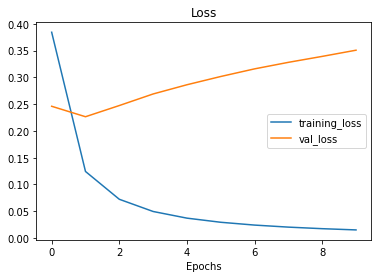

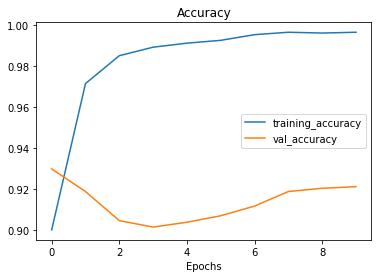

In [62]:
plot_loss_curves(history_1)

##2. LSTM Model

In [63]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.LSTM(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_2 = tf.keras.Model(inputs, outputs)

In [64]:
model_2.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 790)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 790, 128)          1280000   
                                                                 
 lstm_2 (LSTM)               (None, 790, 64)           49408     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                           

In [65]:
model_2.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(),
    metrics = ['accuracy'],
)

history_2 = model_2.fit(
    train_dataset,
    epochs = 10,
    validation_data = val_dataset,
    callbacks = [
              early_stopping,   
    ]
)

Epoch 1/10
159/159 [==============================] - 51s 292ms/step - loss: 0.5285 - accuracy: 0.7178 - val_loss: 0.6132 - val_accuracy: 0.6298 - lr: 0.0010
Epoch 2/10
159/159 [==============================] - 45s 283ms/step - loss: 0.5806 - accuracy: 0.6809 - val_loss: 0.4985 - val_accuracy: 0.7616 - lr: 0.0010
Epoch 3/10
159/159 [==============================] - 45s 285ms/step - loss: 0.3992 - accuracy: 0.7956 - val_loss: 0.5345 - val_accuracy: 0.6590 - lr: 0.0010
Epoch 4/10
159/159 [==============================] - ETA: 0s - loss: 0.5286 - accuracy: 0.7097
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
159/159 [==============================] - 47s 299ms/step - loss: 0.5286 - accuracy: 0.7097 - val_loss: 0.6983 - val_accuracy: 0.5201 - lr: 0.0010
Epoch 5/10
159/159 [==============================] - 45s 284ms/step - loss: 0.6916 - accuracy: 0.5219 - val_loss: 0.6884 - val_accuracy: 0.5683 - lr: 5.0000e-04


In [66]:
model_2_pred = model_2.predict(val_news)
model_2_pred = tf.squeeze(tf.round(model_2_pred))
model_2_result = calculate_result(val_label, model_2_pred)
model_2_result

{'accurecy': 0.7616416732438832,
 'f1-score': 0.7537838705456844,
 'precision': 0.8144156444088506,
 'recall': 0.7616416732438832}

##GRU Layer Model

In [67]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_4 = tf.keras.Model(inputs, outputs)

In [68]:
model_4.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 790)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 790, 128)          1280000   
                                                                 
 gru (GRU)                   (None, 790, 64)           37248     
                                                                 
 lstm_4 (LSTM)               (None, 64)                33024     
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                           

In [69]:
model_4.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(),
    metrics = ['accuracy']
)

history_4 = model_4.fit(
    train_dataset,
    epochs = 10,
    validation_data = val_dataset,
    callbacks = [
              early_stopping,   
    ]
)

Epoch 1/10
159/159 [==============================] - 52s 302ms/step - loss: 0.5567 - accuracy: 0.6924 - val_loss: 0.5037 - val_accuracy: 0.7245 - lr: 0.0010
Epoch 2/10
159/159 [==============================] - 48s 299ms/step - loss: 0.4923 - accuracy: 0.7299 - val_loss: 0.6604 - val_accuracy: 0.6330 - lr: 0.0010
Epoch 3/10
159/159 [==============================] - 48s 299ms/step - loss: 0.4804 - accuracy: 0.7757 - val_loss: 0.4154 - val_accuracy: 0.8429 - lr: 0.0010
Epoch 4/10
159/159 [==============================] - 48s 302ms/step - loss: 0.2297 - accuracy: 0.9315 - val_loss: 0.2677 - val_accuracy: 0.9163 - lr: 0.0010
Epoch 5/10
159/159 [==============================] - 48s 302ms/step - loss: 0.1861 - accuracy: 0.9444 - val_loss: 1.3010 - val_accuracy: 0.5588 - lr: 0.0010
Epoch 6/10
159/159 [==============================] - ETA: 0s - loss: 0.3630 - accuracy: 0.8493
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
159/159 [=========================

In [70]:
model_4_pred = model_4.predict(val_news)
model_4_pred = tf.squeeze(tf.round(model_4_pred))
model_4_result = calculate_result(val_label, model_4_pred)
model_4_result

{'accurecy': 0.9163378058405682,
 'f1-score': 0.9162330816304424,
 'precision': 0.9169046313404066,
 'recall': 0.9163378058405682}

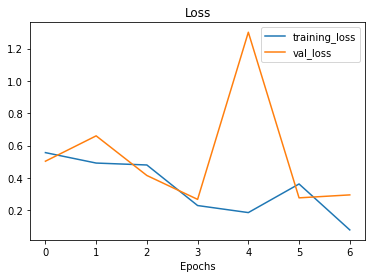

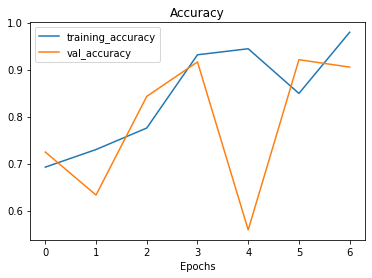

In [71]:
plot_loss_curves(history_4)

In [73]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64, return_sequences=True)(x)
x = layers.LSTM(64)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_5 = tf.keras.Model(inputs, outputs)

model_5.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(),
    metrics = ['accuracy']
)

history_5 = model_5.fit(
    train_dataset,
    epochs = 10,
    validation_data = val_dataset,
    callbacks = [
              early_stopping,   
    ]
)

Epoch 1/10
159/159 [==============================] - 54s 252ms/step - loss: 0.6398 - accuracy: 0.6300 - val_loss: 0.5861 - val_accuracy: 0.6890 - lr: 0.0010
Epoch 2/10
159/159 [==============================] - 39s 243ms/step - loss: 0.3509 - accuracy: 0.8712 - val_loss: 1.0337 - val_accuracy: 0.5107 - lr: 0.0010
Epoch 3/10
159/159 [==============================] - ETA: 0s - loss: 0.6032 - accuracy: 0.6509
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
159/159 [==============================] - 38s 238ms/step - loss: 0.6032 - accuracy: 0.6509 - val_loss: 0.5897 - val_accuracy: 0.6843 - lr: 0.0010
Epoch 4/10
159/159 [==============================] - 44s 278ms/step - loss: 0.3213 - accuracy: 0.8644 - val_loss: 0.5805 - val_accuracy: 0.6251 - lr: 5.0000e-04
Epoch 5/10
159/159 [==============================] - 47s 298ms/step - loss: 0.2542 - accuracy: 0.9225 - val_loss: 0.3088 - val_accuracy: 0.8958 - lr: 5.0000e-04
Epoch 6/10
159/159 [=================

In [74]:
model_5_pred = model_5.predict(val_news)
model_5_pred = tf.squeeze(tf.round(model_5_pred))
model_5_result = calculate_result(val_label, model_5_pred)
model_5_result

{'accurecy': 0.8697711128650355,
 'f1-score': 0.8697711128650355,
 'precision': 0.8725942133868613,
 'recall': 0.8697711128650355}

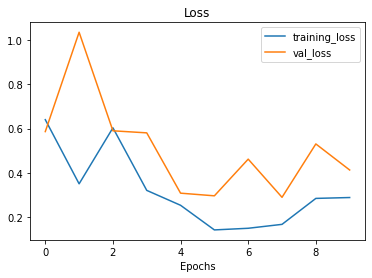

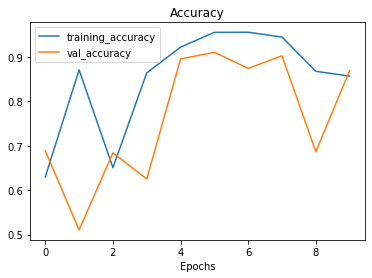

In [75]:
plot_loss_curves(history_5)

##Bidirectional LSTM Model

In [76]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
x = layers.LSTM(64)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_6 = tf.keras.Model(inputs, outputs)

In [77]:
model_6.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 790)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 790, 128)          1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 790, 128)         98816     
 l)                                                              
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dense_11 (Dense)            (None, 1)                 65  

In [78]:
model_6.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(),
    metrics = ['accuracy']
)

model_6.fit(
    train_dataset,
    epochs = 10,
    validation_data = val_dataset,
    callbacks = [
              early_stopping,   
    ]
)

Epoch 1/10
159/159 [==============================] - 61s 349ms/step - loss: 0.3283 - accuracy: 0.8670 - val_loss: 0.4696 - val_accuracy: 0.8098 - lr: 0.0010
Epoch 2/10
159/159 [==============================] - 52s 325ms/step - loss: 0.4200 - accuracy: 0.7972 - val_loss: 0.5695 - val_accuracy: 0.7214 - lr: 0.0010
Epoch 3/10
159/159 [==============================] - 50s 316ms/step - loss: 0.4316 - accuracy: 0.8074 - val_loss: 0.3719 - val_accuracy: 0.8414 - lr: 0.0010
Epoch 4/10
159/159 [==============================] - 52s 328ms/step - loss: 0.1917 - accuracy: 0.9317 - val_loss: 0.2265 - val_accuracy: 0.9061 - lr: 0.0010
Epoch 5/10
159/159 [==============================] - 49s 308ms/step - loss: 0.1423 - accuracy: 0.9483 - val_loss: 0.2089 - val_accuracy: 0.9227 - lr: 0.0010
Epoch 6/10
159/159 [==============================] - 49s 307ms/step - loss: 0.0449 - accuracy: 0.9878 - val_loss: 0.2472 - val_accuracy: 0.9321 - lr: 0.0010
Epoch 7/10
159/159 [==============================] 

In [79]:
model_6_pred = model_6.predict(val_news)
model_6_pred = tf.squeeze(tf.round(model_6_pred))
model_6_result = calculate_result(val_label, model_6_pred)
model_6_result

{'accurecy': 0.936069455406472,
 'f1-score': 0.936067381015211,
 'precision': 0.9360664746280992,
 'recall': 0.936069455406472}

##Conv1D Model

In [80]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(
    filters = 64,
    kernel_size = 5,
    padding = 'valid',
    activation='relu',
)(x)
x = layers.GlobalMaxPool1D()(x)
x = layers.Dense(32, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model_7 = tf.keras.Model(inputs, outputs)

In [81]:
model_7.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 790)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 790, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 786, 64)           41024     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense_12 (Dense)            (None, 32)                2080

In [82]:
model_7.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(),
    metrics = ['accuracy']
)

history_7 = model_7.fit(
    train_dataset,
    epochs = 10,
    validation_data = val_dataset,
    callbacks = [
              early_stopping,   
    ]
)

Epoch 1/10
159/159 [==============================] - 11s 25ms/step - loss: 0.2036 - accuracy: 0.9144 - val_loss: 0.2878 - val_accuracy: 0.8832 - lr: 0.0010
Epoch 2/10
159/159 [==============================] - 3s 22ms/step - loss: 0.1246 - accuracy: 0.9538 - val_loss: 0.2916 - val_accuracy: 0.8879 - lr: 0.0010
Epoch 3/10
157/159 [============================>.] - ETA: 0s - loss: 0.0792 - accuracy: 0.9761
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
159/159 [==============================] - 3s 22ms/step - loss: 0.0787 - accuracy: 0.9763 - val_loss: 0.3236 - val_accuracy: 0.8911 - lr: 0.0010
Epoch 4/10
159/159 [==============================] - 3s 22ms/step - loss: 0.0524 - accuracy: 0.9842 - val_loss: 0.2811 - val_accuracy: 0.9069 - lr: 5.0000e-04
Epoch 5/10
159/159 [==============================] - 3s 22ms/step - loss: 0.0331 - accuracy: 0.9933 - val_loss: 0.2540 - val_accuracy: 0.9227 - lr: 5.0000e-04
Epoch 6/10
159/159 [==========================

In [83]:
model_7_pred = model_7.predict(val_news)
model_7_pred = tf.squeeze(tf.round(model_7_pred))
model_7_result = calculate_result(val_label, model_7_pred)
model_7_result

{'accurecy': 0.9242304656669298,
 'f1-score': 0.9241452070364926,
 'precision': 0.9247268298970897,
 'recall': 0.9242304656669298}

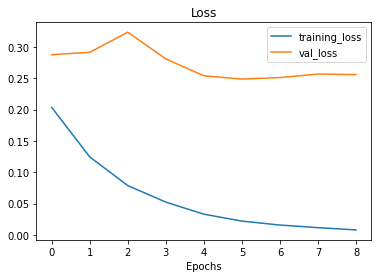

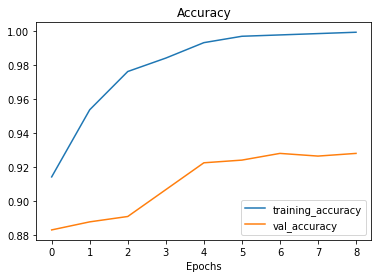

In [84]:
plot_loss_curves(history_7)

##Pretrained Model

In [85]:
import tensorflow_hub as hub

embed = hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')

In [86]:
sentence_encoder_layer = hub.KerasLayer(
    'https://tfhub.dev/google/universal-sentence-encoder/4',
    input_shape=[],
    dtype = tf.string,
    trainable =False,
    name = "USE"
)

In [87]:
model_8 = tf.keras.Sequential([
    sentence_encoder_layer,
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
], name = 'modes_7_USE')

model_8.compile(
    loss = 'binary_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy'],
)

In [88]:
model_8.summary()

Model: "modes_7_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_14 (Dense)            (None, 64)                32832     
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [89]:
history_8  = model_8.fit(
    train_dataset,
    epochs = 10,
    validation_data = val_dataset,
    callbacks = [
              early_stopping,   
    ]
)

Epoch 1/10
159/159 [==============================] - 33s 188ms/step - loss: 0.5024 - accuracy: 0.7946 - val_loss: 0.3600 - val_accuracy: 0.8666 - lr: 0.0010
Epoch 2/10
159/159 [==============================] - 27s 172ms/step - loss: 0.3277 - accuracy: 0.8629 - val_loss: 0.3058 - val_accuracy: 0.8816 - lr: 0.0010
Epoch 3/10
159/159 [==============================] - 27s 173ms/step - loss: 0.2910 - accuracy: 0.8743 - val_loss: 0.2905 - val_accuracy: 0.8887 - lr: 0.0010
Epoch 4/10
159/159 [==============================] - 30s 187ms/step - loss: 0.2730 - accuracy: 0.8875 - val_loss: 0.2840 - val_accuracy: 0.8919 - lr: 0.0010
Epoch 5/10
159/159 [==============================] - 29s 185ms/step - loss: 0.2616 - accuracy: 0.8917 - val_loss: 0.2809 - val_accuracy: 0.8927 - lr: 0.0010
Epoch 6/10
159/159 [==============================] - 29s 184ms/step - loss: 0.2534 - accuracy: 0.8968 - val_loss: 0.2791 - val_accuracy: 0.8958 - lr: 0.0010
Epoch 7/10
159/159 [==============================] 

In [90]:
model_8_pred = model_8.predict(val_news)
model_8_pred = tf.squeeze(tf.round(model_8_pred))
model_8_result = calculate_result(val_label, model_8_pred)
model_8_result

{'accurecy': 0.8942383583267561,
 'f1-score': 0.8941675334392788,
 'precision': 0.8943829385818337,
 'recall': 0.8942383583267561}

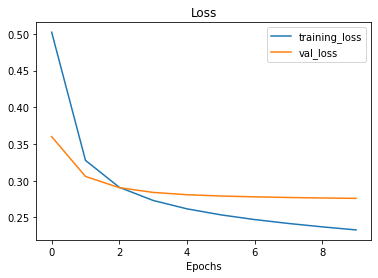

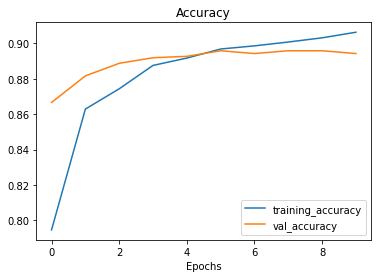

In [91]:
plot_loss_curves(history_8)

#Comparing all Models results

In [92]:
all_model_results = pd.DataFrame({
    '0_NaiveBse_Model': model_0_result,
    '1_simple_dense': model_1_result,
    '2_LSTM': model_2_result,
    '3_GRU_1': model_4_result,
    '4_GRU_2': model_5_result,
    '5_bidirectional': model_6_result,
    '6_conv1D': model_7_result,
    'tf_hub_encoder': model_8_result,
})

In [93]:
all_model_results = all_model_results.transpose()
all_model_results

,accurecy,precision,recall,f1-score
0_NaiveBse_Model,0.773481,0.832729,0.773481,0.765386
1_simple_dense,0.921073,0.921349,0.921073,0.921099
2_LSTM,0.761642,0.814416,0.761642,0.753784
3_GRU_1,0.916338,0.916905,0.916338,0.916233
4_GRU_2,0.869771,0.872594,0.869771,0.869771
5_bidirectional,0.936069,0.936066,0.936069,0.936067
6_conv1D,0.924230,0.924727,0.924230,0.924145
tf_hub_encoder,0.894238,0.894383,0.894238,0.894168


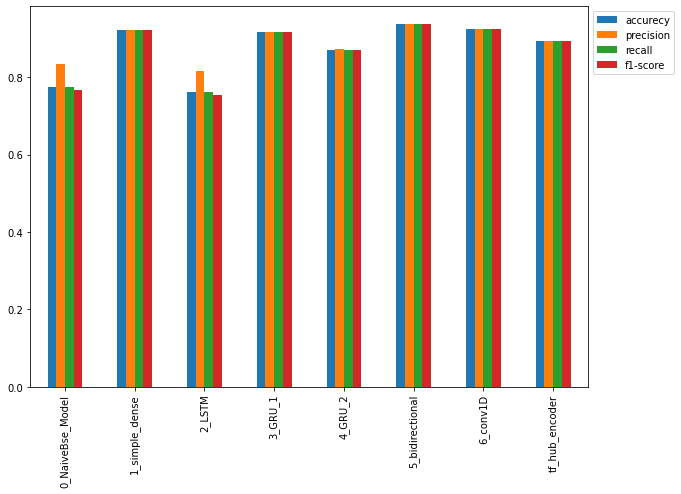

In [94]:
all_model_results.plot(kind='bar', figsize=(10, 7)).legend(bbox_to_anchor=(1.0,1.0));

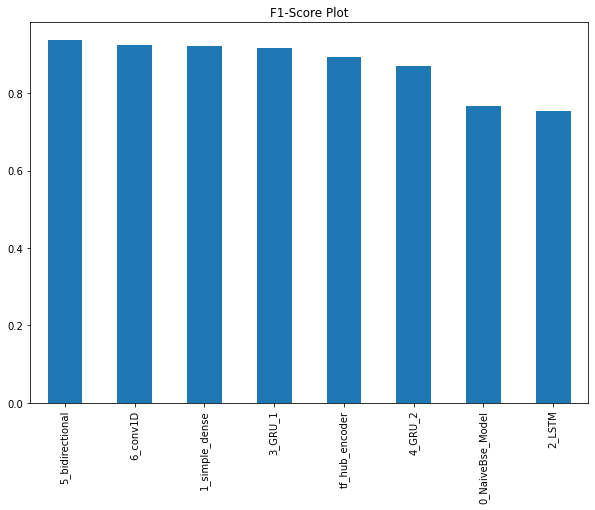

In [95]:
all_model_results.sort_values('f1-score', ascending=False)['f1-score'].plot(kind='bar', figsize=(10, 7))
plt.title('F1-Score Plot');

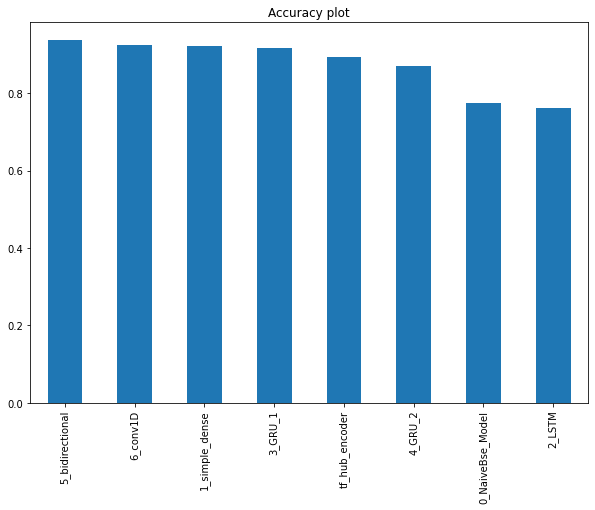

In [96]:
all_model_results.sort_values('accurecy', ascending=False)['accurecy'].plot(kind='bar', figsize=(10, 7))
plt.title('Accuracy plot');

In [97]:
all_model_results.to_csv('Model_Results.csv', index=False)